In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

### load data and labels
### mfcc has various lengths 
import pandas as pd
import numpy as np
import pickle

from imblearn.under_sampling import RandomUnderSampler


In [2]:
def load_mfcc(path):
    
    # Load the concatenated MFCC data
    data = np.load(path)
    return data['X'], data['y']

X_train, y_train = load_mfcc('DAIC_train.npz')
X_test, y_test = load_mfcc('DAIC_test.npz')

# Flatten the MFCC data from 3D to 2D for resampling
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_flattened, y_train)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test_flattened, y_test)

# Check the balance
print("Before balancing:", np.bincount(y_train))
print("After balancing:", np.bincount(y_train_resampled))
print("Before balancing:", np.bincount(y_test))
print("After balancing:", np.bincount(y_test_resampled))

# Optional: Reshape back to 3D if your model requires
X_train_resampled_3d = X_train_resampled.reshape(-1, 40, 200)  # Modify dimensions as necessary
X_test_resampled_3d = X_test_resampled.reshape(-1, 40, 200)  # Modify dimensions as necessary


Before balancing: [4378 1781]
After balancing: [1781 1781]
Before balancing: [967 712]
After balancing: [712 712]


## check zeros

In [59]:
def check_zeros(X):
    all_zero_matrices = []
    zero_rows_matrices = []
    zero_elements_count = []

    for i, matrix in enumerate(X):
        # Check if the entire matrix is zero
        if np.all(matrix == 0):
            all_zero_matrices.append(i)
        
        # Check for zero rows in the matrix
        zero_rows = [idx for idx, row in enumerate(matrix) if np.all(row == 0)]
        if zero_rows:
            zero_rows_matrices.append((i, zero_rows))
        
        # Count zero elements
        zero_elements_count.append(np.sum(matrix == 0))
    
    return all_zero_matrices, zero_rows_matrices, zero_elements_count

# Load your data
X_train, y_train = load_mfcc('DAIC_train.npz')

# Check for zeros
all_zeros, zero_rows, zero_elements = check_zeros(X_train[0:2])

# Print results
print(f"Indices of matrices that are entirely zero: {all_zeros}")
print(f"Indices and rows of matrices that have zero rows: {zero_rows}")
print(f"Number of zero elements in each matrix: {zero_elements}")

Indices of matrices that are entirely zero: []
Indices and rows of matrices that have zero rows: []
Number of zero elements in each matrix: [3360, 2360]


In [3]:
class AudioDataset(Dataset):
    def __init__(self, mfcc_features, labels):
        self.features = torch.FloatTensor(mfcc_features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [61]:
# shuffle X_train_resampled_3d and y_train_resampled, and split into train and validation sets
from sklearn.model_selection import train_test_split
X_train_resampled_3d, X_val_resampled_3d, y_train_resampled, y_val_resampled = train_test_split(X_train_resampled_3d, y_train_resampled, test_size=0.2, random_state=42)

In [5]:
print("After balancing:", np.bincount(y_train_resampled))
print("After balancing:", np.bincount(y_test_resampled))

After balancing: [1781 1781]
After balancing: [712 712]


In [6]:
dataset_train = AudioDataset(X_train_resampled_3d, y_train_resampled)
dataset_val = AudioDataset(X_test_resampled_3d, y_test_resampled)

# use just the train
# dataset_train = AudioDataset(X_train_resampled_3d, y_train_resampled)
# dataset_val = AudioDataset(X_val_resampled_3d, y_val_resampled)

### The model and training

In [19]:
class TCC(nn.Module):
    def __init__(self, input_features=40, sequence_length=200):
        super(TCC, self).__init__()
        
        # Parallel CNN streams (as per paper Section 3.1)
        self.cnn_stream1 = CNNStream()
        self.cnn_stream2 = CNNStream()
        
        # Transformer stream with linear attention
        self.transformer_stream = TransformerStream(input_features, sequence_length)
        
        # Fusion layer
        cnn_out_size = 64 * (sequence_length // 8)  # After 3 max pooling layers
        transformer_out_size = 512 # not used anymore


        # total_features = (cnn_out_size * 2) + transformer_out_size
        total_features = (cnn_out_size * 2) + 128  # reduced from 512

        
        self.fusion = nn.Sequential(
            nn.Linear(total_features, 128), #reduce the number of features 512 was
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)  # Binary classification # reduced from 512, 256, 128
        )

    def forward(self, x):
        # Parallel processing through streams
        cnn1_out = self.cnn_stream1(x)
        cnn2_out = self.cnn_stream2(x)
        transformer_out = self.transformer_stream(x)
        
        # Flatten and concatenate
        cnn1_out = cnn1_out.flatten(1)
        cnn2_out = cnn2_out.flatten(1)
        
        # Fusion
        combined = torch.cat([cnn1_out, cnn2_out, transformer_out], dim=1)
        output = self.fusion(combined)
        
        return output

class CNNStream(nn.Module):
    def __init__(self):
        super(CNNStream, self).__init__()
        
        # Three conv layers as specified in paper
        self.layers = nn.Sequential(
            # First conv block
            nn.Conv1d(40, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            
            # Second conv block
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            
            # Third conv block
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5)
        )
        
    def forward(self, x):
        return self.layers(x)

class TransformerStream(nn.Module):
    def __init__(self, input_features, sequence_length):
        super(TransformerStream, self).__init__()
        
        self.input_proj = nn.Linear(input_features, 128) # 265 instead of 512
        
        # Four transformer layers with linear attention
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model=128) for _ in range(4) # reduced to 256 from 512 range 4-> 2
        ])
        
        # Output pooling
        self.pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, x):
        # Transform input: [batch, features, seq] -> [batch, seq, features]
        x = x.transpose(1, 2)
        
        # Project to transformer dimension
        x = self.input_proj(x)
        
        # Apply transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
        
        # Global pooling over sequence dimension
        x = x.transpose(1, 2)  # [batch, features, seq]
        x = self.pool(x).squeeze(-1)  # [batch, features]
        
        return x

class TransformerLayer(nn.Module):
    def __init__(self, d_model=512):
        super(TransformerLayer, self).__init__()
        
        # Linear attention with 4 heads
        self.attention = LinearAttention(d_model, n_heads=4)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 1024), # 2048
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, d_model) # 2048? 
        )
        
        # Layer norms
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # Multi-head attention with residual
        attended = self.attention(x)
        x = self.norm1(x + attended)
        
        # Feed-forward with residual
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x

class LinearAttention(nn.Module):
    def __init__(self, d_model, n_heads=4):
        super(LinearAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        
        # Linear projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)
        
        self.elu = nn.ELU()
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Linear projections and reshape to heads
        q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        k = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        v = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        
        # Apply ELU + 1 for positive values (as per paper)
        q = self.elu(q) + 1
        k = self.elu(k) + 1
        
        # Linear attention computation
        k_cumsum = k.sum(dim=1, keepdim=True)
        D_inv = 1.0 / torch.einsum('bhnd,bhnd->bhn', q, k_cumsum)
        context = torch.einsum('bhnd,bhne->bhde', k, v)
        out = torch.einsum('bhnd,bhde,bhn->bhne', q, context, D_inv)
        
        # Reshape and project output
        out = out.contiguous().view(batch_size, seq_len, self.d_model)
        out = self.o_proj(out)
        
        return out

def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=0.001, global_history=None, patience=21):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    best_val_acc = 0
    patience_counter = 0

        # Initialize metric collectors
    global_history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Calculate metrics
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        global_history['train_loss'].append(avg_train_loss*100)
        global_history['val_loss'].append(avg_val_loss*100)
        global_history['train_acc'].append(train_acc)
        global_history['val_acc'].append(val_acc)

        with open('history_TCC_inside_balanced_FINAL.pkl', 'wb') as f:
            pickle.dump(global_history, f)

        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        # validation loss aand accuracy print
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%\n')
        print(40 * '-')
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if val_acc > best_val_acc:
            print(40 * '-')
            print('Model is saved')
            print(40 * '-')
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_TCC_inside_balanced_FINAL.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                # break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%\n')
    
    # Load best model
    # model.load_state_dict(torch.load('best_model.pth'))
    return model, global_history

### Train

In [20]:
BATCH_SIZE = 32
SEQMENT_LENGTH = 200

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

# set for reduced memory usage


# torch.set_default_tensor_type(torch.cuda.FloatTensor)

global_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


model = TCC(input_features=40, sequence_length=SEQMENT_LENGTH) 
model, history = train_model(model, train_loader, val_loader, num_epochs=500, learning_rate=0.0001, global_history=global_history, patience=500)

Using device: cuda
Epoch 1/500
Train Loss: 0.7334, Train Acc: 48.88%
Val Loss: 0.6957, Val Acc: 49.79%

----------------------------------------
Epoch 2/500
Train Loss: 0.7168, Train Acc: 51.15%
Val Loss: 0.6976, Val Acc: 49.58%

----------------------------------------
Epoch 3/500
Train Loss: 0.7027, Train Acc: 53.43%
Val Loss: 0.7022, Val Acc: 50.21%

----------------------------------------
Epoch 4/500
Train Loss: 0.6897, Train Acc: 54.35%
Val Loss: 0.7005, Val Acc: 50.28%

----------------------------------------
Epoch 5/500
Train Loss: 0.6899, Train Acc: 54.41%
Val Loss: 0.7066, Val Acc: 50.21%

----------------------------------------
Epoch 6/500
Train Loss: 0.6797, Train Acc: 56.82%
Val Loss: 0.7173, Val Acc: 49.93%

----------------------------------------
Epoch 7/500
Train Loss: 0.6765, Train Acc: 57.94%
Val Loss: 0.7230, Val Acc: 50.00%

----------------------------------------
Epoch 8/500
Train Loss: 0.6711, Train Acc: 57.58%
Val Loss: 0.7214, Val Acc: 49.93%

--------------

KeyboardInterrupt: 

### Evaluation

In [21]:
# open history_TCC_inside.pkl'
import pickle
with open('history_TCC_inside_balanced_FINAL.pkl', 'rb') as f:
    history = pickle.load(f)

In [23]:
### load the saved model and make predictions best_model.pth
SEQMENT_LENGTH = 200
BATCH_SIZE = 32
model = TCC(input_features=40, sequence_length=SEQMENT_LENGTH) 
model.load_state_dict(torch.load('best_model_TCC_inside_balanced_FINAL.pth'))
model.eval()  # Set the model to evaluation mode

TCC(
  (cnn_stream1): CNNStream(
    (layers): Sequential(
      (0): Conv1d(40, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Dropout(p=0.5, inplace=False)
      (10): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (11): ReLU()
      (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Dropout(p=0.5, inplace=False)
    )
  )
  (cn

### Load dataset

Train is splitted

In [26]:
from sklearn.utils import shuffle


X_train, y_train = load_mfcc('DAIC_train.npz')
X_test, y_test = load_mfcc('DAIC_test.npz')

# shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=33)
X_test, y_test = shuffle(X_test, y_test, random_state=33)

# Flatten the MFCC data from 3D to 2D for resampling
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_flattened, y_train)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test_flattened, y_test)

# Check the balance
print("Before balancing - Train:", np.bincount(y_train))
print("After balancing - Train:", np.bincount(y_train_resampled))
print("Before balancing - Test:", np.bincount(y_test))
print("After balancing - Test:", np.bincount(y_test_resampled))

# Optional: Reshape back to 3D if your model requires
X_train_resampled_3d = X_train_resampled.reshape(-1, 40, 200)  # Modify dimensions as necessary
X_test_resampled_3d = X_test_resampled.reshape(-1, 40, 200)  # Modify dimensions as necessary

dataset_train = AudioDataset(X_train_resampled_3d, y_train_resampled)
dataset_val = AudioDataset(X_test_resampled_3d, y_test_resampled)

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)



Before balancing - Train: [4378 1781]
After balancing - Train: [1781 1781]
Before balancing - Test: [967 712]
After balancing - Test: [712 712]


In [ ]:
# unbalanced validation 
# I dont have time for this. 

# X_train_resampled_3d, X_val_resampled_3d, y_train_resampled, y_val_resampled = train_test_split(X_train_resampled_3d, y_train_resampled, test_size=0.2, random_state=42)

# dataset_val = AudioDataset(X_test, y_test)
# val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to the appropriate device
model.to(device)

def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in loader:
            # Move data to the same device as the model
            data = data.to(device)
            labels = labels.to(device)
            
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Assuming train_loader and val_loader are defined as DataLoader instances
# Get predictions for training data
train_labels, train_preds = get_all_preds(model, train_loader)
train_conf_matrix = confusion_matrix(train_labels, train_preds)

# Get predictions for validation data
val_labels, val_preds = get_all_preds(model, val_loader)
val_conf_matrix = confusion_matrix(val_labels, val_preds)

print("Training Confusion Matrix:\n", train_conf_matrix)
print("Validation Confusion Matrix:\n", val_conf_matrix)



Using device: cuda
Training Confusion Matrix:
 [[ 296 1485]
 [  15 1766]]
Validation Confusion Matrix:
 [[ 61 651]
 [ 44 668]]


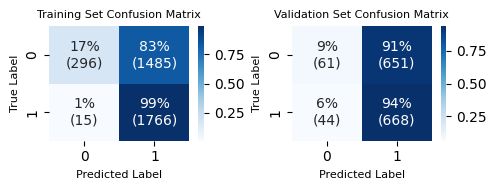

In [31]:
import importlib as imp


import functions_data_viz
imp.reload(functions_data_viz)
from functions_data_viz import plot_precomputed_conf_matrices

# Example usage with your matrices
plot_precomputed_conf_matrices(train_conf_matrix, val_conf_matrix, show_plot="all")